In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax

import icomo

In [2]:
def m(args):
    return args["m_max"] - args["m_max"]/args["H_thres"]*args["m_eps"]\
        * jax.numpy.log( 1+jax.numpy.exp( (args["H_thres"]- args["H"])/args["m_eps"] ))
def lambda_STI(args):
    return args["lambda_0"]\
        + args["c"]*(1-m(args))*args["beta_HIV"]*args["H"]*(1-args["P_HIV"])\
        + args["lambda_P"]*args["P_HIV"]
def infect(y, args):
    return (1-m(args)*(1-args["P_HIV"]))*args["beta_STI"]*y["I_STI"]

def model(t, y, args):
    cm = icomo.CompModel(y)
    
    # basic STI dynamics
    cm.flow("S_STI", "I_STI", args["asymptomatic"]*infect(y, args))
    cm.flow("S_STI", "T_STI", (1-args["asymptomatic"])*infect(y, args))
    cm.flow("I_STI", "S_STI", args["gamma_STI"])
    cm.flow("I_STI", "T_STI", lambda_STI(args))
    cm.flow("T_STI", "S_STI", args["gammaT_STI"])
    # vital dynamics
    cm.flow("I_STI", "S_STI", args["mu"])
    cm.flow("T_STI", "S_STI", args["mu"])
    
    
#    cm.view_graph()
    return cm.dy

args = {
    "beta_HIV": 0.6341/360.,
    "beta_STI": 0.0016              *5.,
    "mu": 1./45./360.,
    "gamma_STI": 1./1.32/360.,
    "gammaT_STI": 1./14.,
#    "gammaT_STI": 1./7.,
    "lambda_0": 0.,
    "lambda_P": 12./9./360.,
    "asymptomatic": 0.9,
    ####
    "m_max": 0.8,
    "H_thres": 0.1,
    "m_eps": 0.01,
    "Phi_r": 40.,
    "H_tau": 20.,
    "c": 50.,
    "H": 0.,
    "P_HIV": 0.,
}

y0 = {
    "S_STI": 0.99,
    "I_STI": 0.01,
    "T_STI": 0.0,
}

In [3]:
ts = np.linspace(0,3600*5,3600)
integrator_object = icomo.ODEIntegrator(
    ts_out = ts,
    t_0 = min(ts),
    ts_solver = ts,
)

integrator = integrator_object.get_func(model)

In [4]:
Hs = np.linspace(0,0.1,101)
Ps = np.linspace(0,0.8,201)
res_size = [len(Hs),len(Ps)]
res_I = np.zeros(res_size)
res_T = np.zeros(res_size)
res_infections = np.zeros(res_size)
res_tests = np.zeros(res_size)
check = np.zeros(res_size)

for i,H in enumerate(Hs):
    for j,P in enumerate(Ps):
        args_mod = args.copy()
        args_mod["H"] = H
        args_mod["P_HIV"] = P
        output = integrator(y0=y0, constant_args=args_mod)
 
        y1 = {key: value[-1] for key, value in output.items()}
        res_I[i,j] = output["I_STI"][-1]
        res_T[i,j] = output["T_STI"][-1]        
        res_infections[i,j] = infect(y1, args_mod) * y1["S_STI"]
        res_tests[i,j] = lambda_STI(args_mod) * y1["I_STI"]
        check[i,j] = abs(output["I_STI"][-1]-output["I_STI"][-101])\
                   + abs(output["T_STI"][-1]-output["T_STI"][-101])
print( check.max() )

0.0002956505684759052


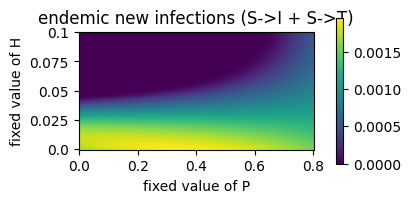

In [5]:
plt.figure(figsize=(4,3), layout='constrained')
plt.imshow(res_infections, origin="lower")
plt.title("endemic new infections (S->I + S->T)")
plt.xlabel("fixed value of P")
plt.ylabel("fixed value of H")
plt.xticks([0,50,100,150,200], [Ps[0],Ps[50],Ps[100],Ps[150],Ps[200]])
plt.yticks([0,25,50,75,100], [Hs[0],Hs[25],Hs[50],Hs[75],Hs[100]])
plt.colorbar(shrink=0.5)

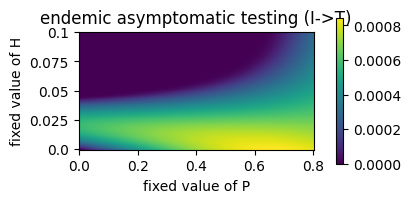

In [6]:
plt.figure(figsize=(4,3), layout='constrained')
plt.imshow(res_tests, origin="lower")
plt.title("endemic asymptomatic testing (I->T)")
plt.xlabel("fixed value of P")
plt.ylabel("fixed value of H")
plt.xticks([0,50,100,150,200], [Ps[0],Ps[50],Ps[100],Ps[150],Ps[200]])
plt.yticks([0,25,50,75,100], [Hs[0],Hs[25],Hs[50],Hs[75],Hs[100]])
plt.colorbar(shrink=0.5)

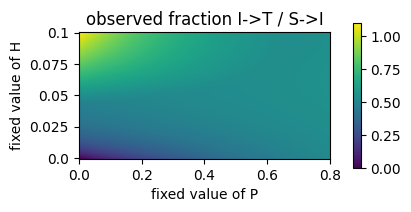

In [7]:
plt.figure(figsize=(4,3), layout='constrained')
plt.imshow(res_tests/res_infections, origin="lower")
plt.title("observed fraction I->T / S->I")
plt.xlabel("fixed value of P")
plt.ylabel("fixed value of H")
plt.xticks([0,50,100,150,200], [Ps[0],Ps[50],Ps[100],Ps[150],Ps[200]])
plt.yticks([0,25,50,75,100], [Hs[0],Hs[25],Hs[50],Hs[75],Hs[100]])
plt.colorbar(shrink=0.5)

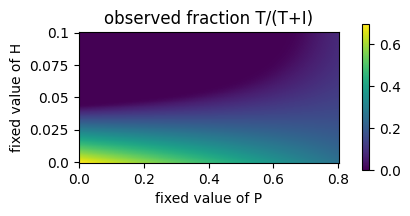

In [8]:
plt.figure(figsize=(4,3), layout='constrained')
plt.imshow(res_I-res_T, origin="lower")
plt.title("observed fraction T/(T+I)")
plt.xlabel("fixed value of P")
plt.ylabel("fixed value of H")
plt.xticks([0,50,100,150,200], [Ps[0],Ps[50],Ps[100],Ps[150],Ps[200]])
plt.yticks([0,25,50,75,100], [Hs[0],Hs[25],Hs[50],Hs[75],Hs[100]])
plt.colorbar(shrink=0.5)

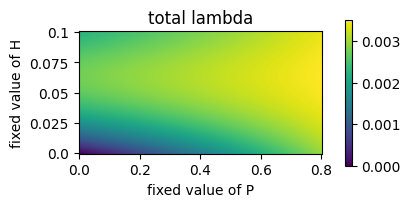

In [9]:
Hs = np.linspace(0,0.1,101)
Ps = np.linspace(0,0.8,201)
lambda_H = np.zeros([len(Hs),len(Ps)])
lambda_P = np.zeros([len(Hs),len(Ps)])
for i,H in enumerate(Hs):
    for j,P in enumerate(Ps):
        m = args["m_max"] - args["m_max"]/args["H_thres"]*args["m_eps"]*\
            np.log( 1+np.exp( (args["H_thres"]- H)/args["m_eps"] ))
        lambda_H[i,j] = args["c"]*(1-m)*args["beta_HIV"]*H*(1-P)
        lambda_P[i,j] = args["lambda_P"]*P

plt.figure(figsize=(4,3), layout='constrained')
plt.imshow(lambda_P+lambda_H+args["lambda_0"], origin="lower")
plt.title("total lambda")
plt.xlabel("fixed value of P")
plt.ylabel("fixed value of H")
plt.xticks([0,50,100,150,200], [Ps[0],Ps[50],Ps[100],Ps[150],Ps[200]])
plt.yticks([0,25,50,75,100], [Hs[0],Hs[25],Hs[50],Hs[75],Hs[100]])
plt.colorbar(shrink=0.5)